In [1]:
from mobster_mv import mobster_MV
from BoundedPareto import BoundedPareto
import numpy as np
import pyro
import pyro.distributions as dist

import torch
from torch.distributions import constraints

import matplotlib.pyplot as plt
import seaborn

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def pareto_binomial_component(alpha, L, H, p, n, N, seed):
    """
    Create pareto-binomial component: 
    x-axis is a Pareto-Binomial
    y-axis is a Beta-Binomial
    """
    pyro.set_rng_seed(seed)
    d1 = torch.ones([N, 2]) # component 1
    
    # x-axis component 1
    for i in range(N):
        p_p = BoundedPareto(scale=L, alpha = alpha, upper_limit = H).sample().float()
        d1[i, 0] = dist.Binomial(total_count=n, probs=p_p).sample().squeeze(-1)
    # p_p = BoundedPareto(scale=L, alpha = alpha, upper_limit = H).sample().float()
    # d1[:, 0] = dist.Binomial(total_count=n, probs=p_p).sample([N]).squeeze(-1)

    d1[:, 1] = dist.Binomial(total_count=n, probs=p).sample([N]).squeeze(-1)
    DP = torch.ones([N, 2]) * n

    return d1, DP
    

In [3]:
def beta_binomial_component(p_x, p_y, n, N,seed):
    """
    Create beta-binomial component: 
    x-axis is a Beta-Binomial
    y-axis is a Beta-Binomial
    """
    pyro.set_rng_seed(seed)
    d2 = torch.ones([N, 2]) # component 2
    # x-axis component 2
    d2[:, 0] = dist.Binomial(total_count=n, probs=p_x).sample([N]).squeeze(-1)
    
    # y-axis component 2
    d2[:, 1] = dist.Binomial(total_count=n, probs=p_y).sample([N]).squeeze(-1)

    DP = torch.ones([N, 2]) * n

    return d2, DP

In [4]:
N1 = 2000
N2 = 1000
seed = 123
NV1, DP1 = pareto_binomial_component(alpha=2, L=0.05, H=0.5, p=0.5, n=100, N=N1, seed = seed)
NV2, DP2 = beta_binomial_component(p_x=0.5, p_y=0.5, n=150, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
print(NV.shape)
# print(NV)
DP = torch.concat((DP1,DP2))
print(DP.shape)
# print(DP) 

torch.Size([3000, 2])
torch.Size([3000, 2])


(array([ 17., 146., 341., 439., 207., 277., 182., 134.,  33.,  59.,  44.,
         23.,  17.,  16.,  11.,   7.,   3.,   5.,   8.,   2.,   8.,   4.,
          5.,   2.,   0.,   1.,   3.,   3.,   1.,   2.]),
 array([0.        , 0.01766667, 0.03533333, 0.053     , 0.07066666,
        0.08833333, 0.10599999, 0.12366666, 0.14133333, 0.15899999,
        0.17666666, 0.19433333, 0.21199998, 0.22966665, 0.24733332,
        0.26499999, 0.28266665, 0.30033332, 0.31799999, 0.33566666,
        0.35333332, 0.37099999, 0.38866666, 0.4063333 , 0.42399997,
        0.44166663, 0.4593333 , 0.47699997, 0.49466664, 0.51233333,
        0.52999997]),
 <BarContainer object of 30 artists>)

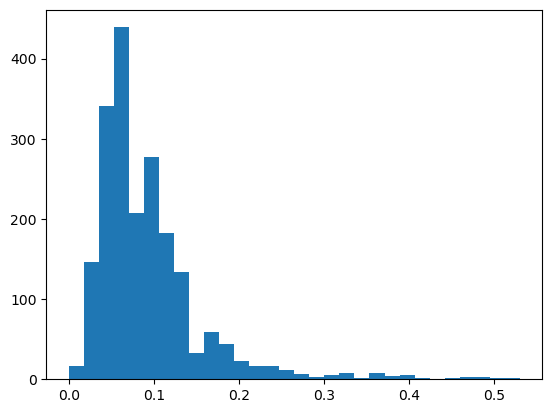

In [5]:
plt.hist(NV1[:,0].numpy()/DP1[:,0].numpy(), bins = 30)

In [6]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
    
labels = np.concatenate((labels_1, labels_2))

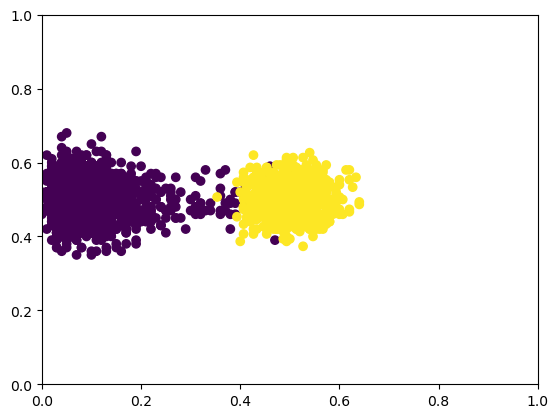

In [7]:
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

In [8]:
mb = mobster_MV(NV, DP, K = 2, seed = 12)

tensor([[0.0868, 0.4993],
        [0.4951, 0.5026]], grad_fn=<ClampBackward1>)
Iteration 0: Loss = 88508656.0
tensor([[0.0869, 0.4990],
        [0.4954, 0.5023]], grad_fn=<ClampBackward1>)
tensor([[0.0870, 0.4992],
        [0.4952, 0.5024]], grad_fn=<ClampBackward1>)
tensor([[0.0871, 0.4992],
        [0.4951, 0.5024]], grad_fn=<ClampBackward1>)
tensor([[0.0871, 0.4993],
        [0.4951, 0.5025]], grad_fn=<ClampBackward1>)
tensor([[0.0872, 0.4993],
        [0.4951, 0.5026]], grad_fn=<ClampBackward1>)
tensor([[0.0873, 0.4993],
        [0.4952, 0.5027]], grad_fn=<ClampBackward1>)
tensor([[0.0874, 0.4993],
        [0.4953, 0.5027]], grad_fn=<ClampBackward1>)
tensor([[0.0875, 0.4992],
        [0.4953, 0.5027]], grad_fn=<ClampBackward1>)
tensor([[0.0875, 0.4992],
        [0.4953, 0.5026]], grad_fn=<ClampBackward1>)
tensor([[0.0876, 0.4992],
        [0.4953, 0.5025]], grad_fn=<ClampBackward1>)
tensor([[0.0877, 0.4992],
        [0.4952, 0.5024]], grad_fn=<ClampBackward1>)
tensor([[0.0878, 0.49

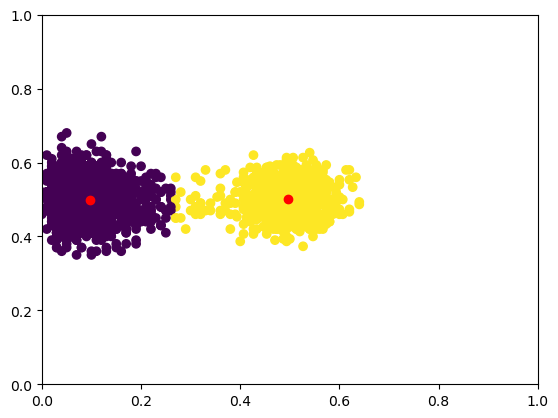

In [9]:
mb.fit(num_iter = 2000, lr = 0.001)

In [10]:
from sklearn.metrics.cluster import normalized_mutual_info_score
nmi = normalized_mutual_info_score(labels, mb.params['cluster_assignments']) # normalized_mutual_info_score(labels_true, labels_pred)
print(nmi) # 0 (no mutual information) and 1 (perfect correlation)

0.880302928482046


In [29]:
mb.params['responsib'].T.shape

torch.Size([3000, 2])

[[1.0000000e+00 2.1066647e-22]
 [1.0000000e+00 2.2260494e-22]
 [1.0000000e+00 2.1358928e-22]
 ...
 [7.6861934e-36 1.0000000e+00]
 [5.5241440e-32 1.0000000e+00]
 [3.6067999e-24 1.0000000e+00]]


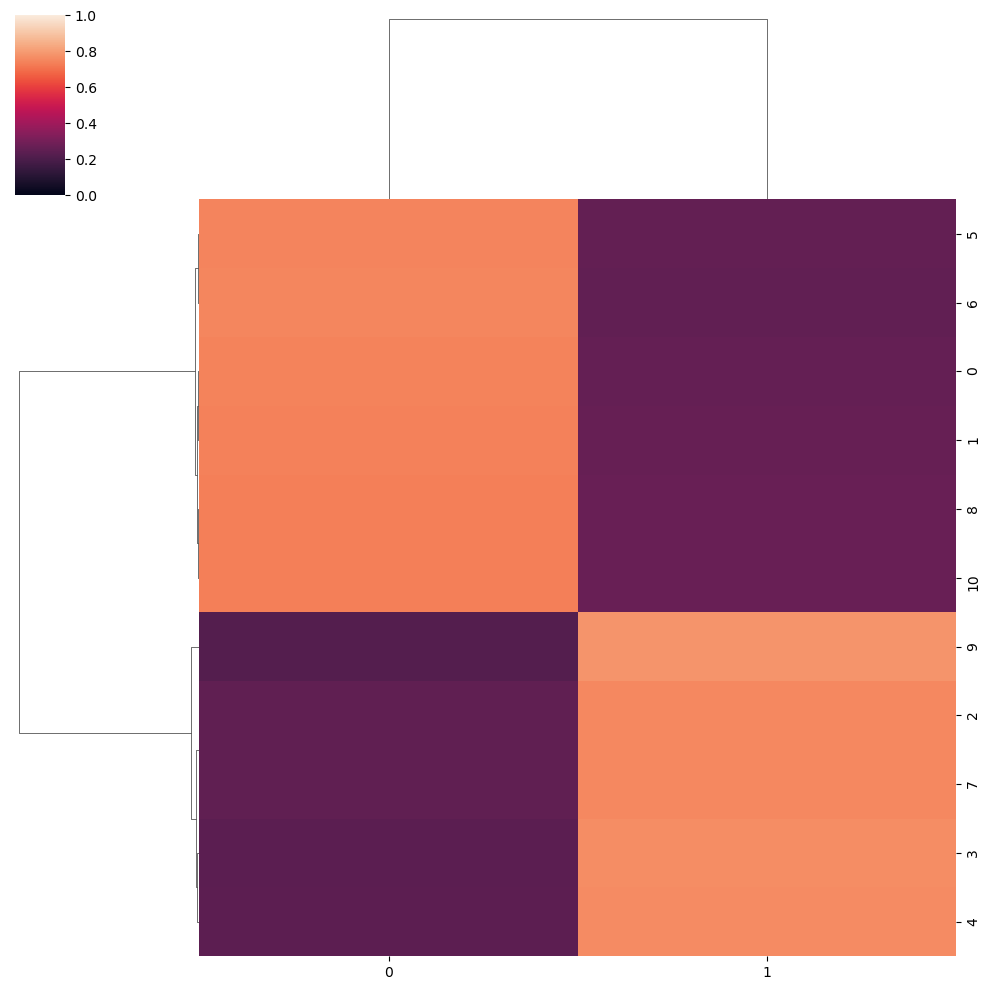

In [46]:
a = mb.params['responsib'].T
a = a.numpy()
print(a)
seaborn.clustermap(a[(a[:,0] > 0.2)  & (a[:,0] < 0.8)], vmin=0, vmax=1)
# mb.params['responsib'].T[torch.any(a, 1),:]
# # seaborn.clustermap(a.numpy().T)

In [45]:
mb.params

{'probs_bin': tensor([[0.0965, 0.4992],
         [0.4959, 0.5026]]),
 'weights': tensor([0.6036, 0.3964]),
 'delta': tensor([[[0.3652, 0.6348],
          [0.0840, 0.9160]],
 
         [[0.2567, 0.7433],
          [0.0618, 0.9382]]]),
 'alpha_pareto': tensor([[0.5614, 0.9032],
         [0.5721, 0.8185]]),
 'responsib': tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 7.6862e-36, 5.5241e-32,
          3.6068e-24],
         [2.1067e-22, 2.2260e-22, 2.1359e-22,  ..., 1.0000e+00, 1.0000e+00,
          1.0000e+00]]),
 'cluster_assignments': tensor([0, 0, 0,  ..., 1, 1, 1])}

Using 3 components

In [10]:
N1 = 2000
N2 = 1000
N3 = 2000
NV1, DP1 = pareto_binomial_component(alpha=2, L=0.05, H=0.5, p=0.5, n=100, N=N1, seed = 123)
NV2, DP2 = beta_binomial_component(p_x=0.5, p_y=0.5, n=150, N=N2, seed=123)
NV3, DP3 = beta_binomial_component(p_x=0.3, p_y=0.3, n=150, N=N3, seed=123)
NV = torch.concat((NV1,NV2))
NV = torch.concat((NV,NV3))
print(NV.shape)
# print(NV)
DP = torch.concat((DP1,DP2))
DP = torch.concat((DP,DP3))
print(DP.shape)
# print(DP) 

torch.Size([5000, 2])
torch.Size([5000, 2])


In [11]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels_3 = np.ones(N3) * 3

labels = np.concatenate((labels_1, labels_2))
labels = np.concatenate((labels, labels_3))

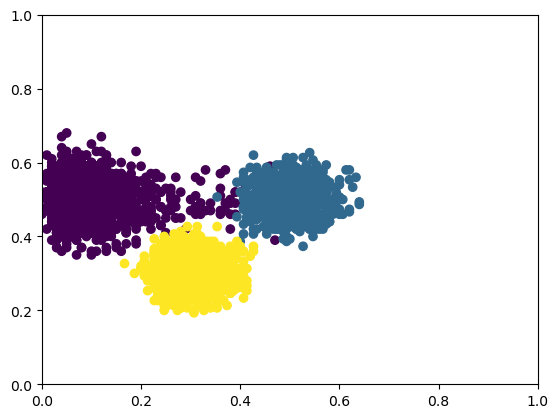

In [12]:
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

In [14]:
mb = mobster_MV(NV, DP, K = 3, seed = 12)

tensor([[0.0856, 0.4998],
        [0.3014, 0.3020],
        [0.4965, 0.5030]], grad_fn=<ClampBackward1>)
Iteration 0: Loss = 223764080.0
tensor([[0.0856, 0.4996],
        [0.3012, 0.3018],
        [0.4963, 0.5027]], grad_fn=<ClampBackward1>)
tensor([[0.0855, 0.4997],
        [0.3010, 0.3016],
        [0.4960, 0.5025]], grad_fn=<ClampBackward1>)
tensor([[0.0854, 0.4999],
        [0.3008, 0.3014],
        [0.4958, 0.5022]], grad_fn=<ClampBackward1>)
tensor([[0.0853, 0.5000],
        [0.3007, 0.3012],
        [0.4956, 0.5020]], grad_fn=<ClampBackward1>)
tensor([[0.0852, 0.5000],
        [0.3006, 0.3011],
        [0.4953, 0.5018]], grad_fn=<ClampBackward1>)
tensor([[0.0852, 0.4999],
        [0.3006, 0.3010],
        [0.4951, 0.5016]], grad_fn=<ClampBackward1>)
tensor([[0.0851, 0.4998],
        [0.3007, 0.3009],
        [0.4949, 0.5015]], grad_fn=<ClampBackward1>)
tensor([[0.0850, 0.4997],
        [0.3007, 0.3009],
        [0.4947, 0.5014]], grad_fn=<ClampBackward1>)
tensor([[0.0849, 0.4997

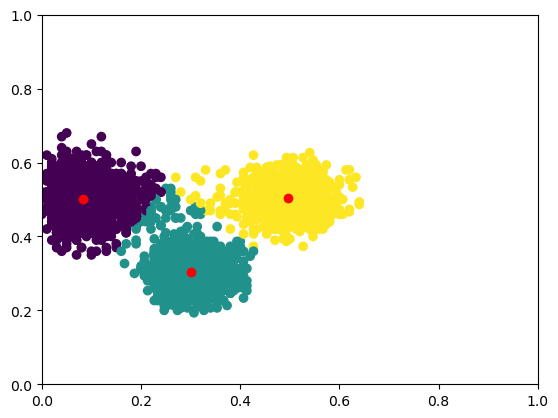

In [15]:
mb.fit(num_iter = 2000, lr = 0.001)

Using 4 components (1 beta private)

In [52]:
N1 = 2000
N2 = 1000
N3 = 2000
N4 = 1000
NV1, DP1 = pareto_binomial_component(alpha=2, L=0.05, H=0.5, p=0.5, n=100, N=N1, seed = 123)
NV2, DP2 = beta_binomial_component(p_x=0.5, p_y=0.5, n=150, N=N2, seed=123)
NV3, DP3 = beta_binomial_component(p_x=0.3, p_y=0.3, n=150, N=N3, seed=123)
NV4, DP4 = beta_binomial_component(p_x=0.3, p_y=0.0, n=150, N=N4, seed=123)
NV = torch.concat((NV1,NV2))
NV = torch.concat((NV,NV3))
NV = torch.concat((NV,NV4))
print(NV.shape)
# print(NV)
DP = torch.concat((DP1,DP2))
DP = torch.concat((DP,DP3))
DP = torch.concat((DP,DP4))
print(DP.shape)
# print(DP) 

torch.Size([6000, 2])
torch.Size([6000, 2])


In [53]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels_3 = np.ones(N3) * 3
labels_4 = np.ones(N4) * 4

labels = np.concatenate((labels_1, labels_2))
labels = np.concatenate((labels, labels_3))
labels = np.concatenate((labels, labels_4))

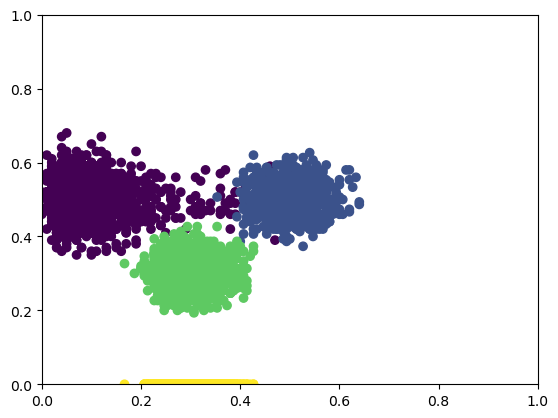

In [54]:
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

In [55]:
mb = mobster_MV(NV, DP, K = 4, seed = 12)

tensor([[8.5637e-02, 4.9982e-01],
        [3.0139e-01, 3.0203e-01],
        [4.9654e-01, 5.0297e-01],
        [3.0095e-01, 1.1755e-38]], grad_fn=<ClampBackward1>)
Iteration 0: Loss = 323165312.0
tensor([[8.5716e-02, 5.0007e-01],
        [3.0118e-01, 3.0182e-01],
        [4.9629e-01, 5.0272e-01],
        [3.0074e-01, 1.1755e-38]], grad_fn=<ClampBackward1>)
tensor([[8.5794e-02, 4.9998e-01],
        [3.0099e-01, 3.0161e-01],
        [4.9605e-01, 5.0247e-01],
        [3.0058e-01, 1.1755e-38]], grad_fn=<ClampBackward1>)
tensor([[8.5871e-02, 4.9982e-01],
        [3.0080e-01, 3.0140e-01],
        [4.9583e-01, 5.0224e-01],
        [3.0043e-01, 1.1755e-38]], grad_fn=<ClampBackward1>)
tensor([[8.5948e-02, 4.9968e-01],
        [3.0065e-01, 3.0121e-01],
        [4.9561e-01, 5.0201e-01],
        [3.0026e-01, 1.1755e-38]], grad_fn=<ClampBackward1>)
tensor([[8.6021e-02, 4.9958e-01],
        [3.0054e-01, 3.0102e-01],
        [4.9540e-01, 5.0180e-01],
        [3.0011e-01, 1.1755e-38]], grad_fn=<ClampBa

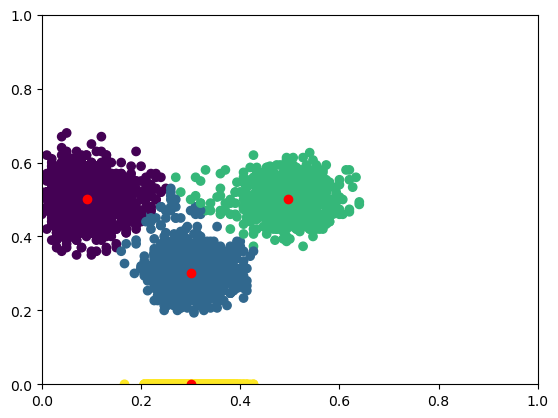

In [56]:
mb.fit(num_iter = 2000, lr = 0.001)